In [1]:
from dotenv import load_dotenv

load_dotenv()

import os

import numpy as np
from datasets import load_dataset, concatenate_datasets
import nltk
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim import models, corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

In [2]:
# define hyperparams
num_topics_fraction = 1.0/20
num_words_per_topic = 3
n = 10_0
num_passes = 1
filter_below = 2
filter_above_frac = 0.4
# defines how discriminative topics are associated to a post
alpha = 1.0 / (n * num_topics_fraction)
use_bigrams=True

In [3]:
print("Downloading datasets...")
# load datasets
# tweets labeled with democrats/republicans
political_tweets = load_dataset("Jacobvs/PoliticalTweets", split="train")
#political_comments = load_dataset("jbochenek/political", split="train")
#twitter_financial_news = load_dataset("zeroshot/twitter-financial-news-topic", split="train")
#political_justifications = load_dataset("od21wk/political_news_justifications", split="train")
#real_and_fake_news = load_dataset("GonzaloA/fake_news", split="train")
# already tokenized
#covid_vaccine_attitudes = load_dataset("webimmunization/COVID-19-vaccine-attitude-tweets")
#covid_vaccine_conspiracy = load_dataset("webimmunization/COVID-19-conspiracy-theories-tweets")

print("Download finished. Start with preprocessing")
posts = concatenate_datasets(
    [
        political_tweets,
        #political_comments,
        #twitter_financial_news,
        #political_justifications,
        #real_and_fake_news,
        #covid_vaccine_attitudes,
        #covid_vaccine_conspiracy,
    ]
).to_dict()["text"]
posts = [sample for sample in posts if sample is not None]

Download finished. Start with preprocessing


In [4]:
def seed_words():
    return [
        "politics",
        "economy",
        "party",
        "war",
        "conflict",
        "democrats",
        "republicans",
        "diplomacy",
        "climate",
        "democracy",
        "voting"
    ]

def custom_stop_words():
    custom_stopwords = stopwords.words("english")
    custom_stopwords += [
        "https",
        "co",
        "subscribe",
        "com",
        "today",
    ]
    # TODO: add custom stopwords
    return custom_stopwords
    
def custom_stop_ids(dict):
    custom_stopwords = custom_stop_words()
    stop_ids = [dict.token2id[stopword] for stopword in custom_stopwords
                if stopword in dict.token2id]
    return stop_ids


def preprocess(sample):
    # remove non-alphanumeric chars
    # lower-case text
    # tokenize sentences
    # tokenize words

    tokenized_sent = sent_tokenize(sample, "english")
    tokenized_words = []
    custom_stopwords = custom_stop_words()
    for sentence in tokenized_sent:
        cleaned_sent = re.sub("[^a-zA-Z]", " ", sentence)
        cleaned_sent = cleaned_sent.lower()
        sent_words = word_tokenize(cleaned_sent, "english")
        if use_bigrams:
            for idx in range(len(sent_words) - 1):
                if sent_words[idx] not in custom_stopwords and sent_words[idx + 1] not in custom_stopwords:
                    tokenized_words.append(sent_words[idx] + "_" + sent_words[idx + 1])
        else:
            tokenized_words.extend(sent_words)
    tokenized_words = list(filter(lambda word: len(word) > 1, tokenized_words))
    return tokenized_words


In [5]:
# data preprocessing
#nltk.download("punkt")
#nltk.download("stopwords")
stemmer = nltk.stem.PorterStemmer()

posts = list(map(lambda post: preprocess(post), posts))
dict = corpora.Dictionary(posts)
print("number of tokens: ", len(dict))
dict.filter_extremes(no_below=filter_below, no_above=filter_above_frac)
dict.compactify()
# filter stop words (e.g. 'I', 'are', ...)
dict.filter_tokens(bad_ids=custom_stop_ids(dict))
# define word corpus (bag of words)
corpus = [dict.doc2bow(word) for word in posts]
print("number of cleaned tokens: ", len(dict))


[nltk_data] Downloading package punkt to /home/inet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/inet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# define and train model
print("Start model training...")
num_topics = n * num_topics_fraction
model = models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dict, passes=num_passes)
topics = model.print_topics(num_words=num_words_per_topic)
for topic in topics:
    print(topic)

# save model
print("Finished model training.")
model_name = "model_t{}_w{}".format(num_topics, num_words_per_topic)
model.save(model_name)

Start model training...


NameError: name 'corpus' is not defined

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

diversity = 0.3
n_grams_max = 5

# remove custom stop words after embeddings are created to guarantee full context
vectorizer_model = CountVectorizer(stop_words=custom_stop_words())
# use tfidf transformer to reduce the impact of frequent words
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# diversify words to describe topics
representation_model = MaximalMarginalRelevance(diversity=diversity)
# alternative modeling -> BERTopic
bertopic_model = BERTopic("english",
                          n_gram_range=(1, n_grams_max), 
                          vectorizer_model=vectorizer_model,
                          ctfidf_model=ctfidf_model,
                          representation_model=representation_model
                          )
bert_data = political_tweets.to_dict()["text"][:10000]
topics, probs = bertopic_model.fit_transform(bert_data)
print(topics)
print(probs)
bertopic_model.get_topic_info()

/Users/a.gube/IdeaProjects/23ws-ase-pr-inso-01/topic_modeling_training/topic_modeling_training/py11/venv/lib/python3.11/site-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)


[19, 4, 4, 31, 19, 13, 4, -1, 22, 3, 107, 26, 25, 7, 3, 10, 2, 2, -1, 0, -1, 150, 92, -1, -1, -1, 58, 5, 15, 13, 50, -1, -1, 4, 7, 28, -1, 7, 42, 144, 40, 89, 1, -1, 6, 69, 2, 61, -1, 70, -1, 77, 25, 51, -1, -1, -1, 38, 1, -1, 1, -1, 67, -1, 75, -1, 21, -1, -1, -1, 7, -1, -1, 70, 152, 52, 1, -1, 157, 32, 40, 24, 57, 155, -1, -1, 54, 46, 9, -1, 136, -1, -1, 112, 16, 1, 5, -1, 20, -1, -1, 39, 156, 5, 105, 3, 8, 91, 2, 3, -1, 154, 31, 3, 2, 16, 10, 142, 21, 59, -1, 13, -1, 99, 0, 69, 60, 2, 6, -1, 5, -1, -1, -1, 76, -1, -1, 29, 70, -1, -1, -1, 36, 100, 70, 1, 19, 0, 8, 70, -1, 38, 4, 1, 30, -1, 35, 15, -1, 20, -1, 12, 12, 4, 81, 0, 1, 9, 114, -1, 80, -1, -1, 37, -1, 1, -1, 52, 18, 9, 14, 81, 107, -1, -1, -1, -1, 82, 63, -1, -1, -1, 55, -1, 48, 94, 43, 159, 69, 46, 71, 82, 4, 116, 142, -1, 49, 77, -1, -1, -1, 91, 30, 1, -1, 159, 44, -1, 34, 28, -1, 32, 49, 90, 91, 59, -1, 116, 97, 7, -1, 10, 29, -1, 4, 1, 88, 8, 39, -1, 19, -1, -1, -1, 48, -1, 10, 21, 24, 7, -1, -1, -1, 2, 98, 16, -1, 143,

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3276,-1_farmers_iowa_energy_county,"[farmers, iowa, energy, county, georgia, stimu...",[Carl Levin was selflessly dedicated to his ho...
1,0,271,0_vaccinated_vaccines_shot_doses,"[vaccinated, vaccines, shot, doses, near, covi...",[Big milestone: The FDA has fully approved the...
2,1,252,1_afghanistan_taliban_afghan_afghans,"[afghanistan, taliban, afghan, afghans, strand...",[I'm closely monitoring the situation unfoldin...
3,2,216,2_migrants_patrol_borders_immigration,"[migrants, patrol, borders, immigration, cbp, ...","[Border Patrol is overwhelmed, overworked, and..."
4,3,192,3_yep_tune_httpstconxu8ngfqrj_httpstcorvwwrmfhki,"[yep, tune, httpstconxu8ngfqrj, httpstcorvwwrm...",[Check out StormTools for a complete picture o...
...,...,...,...,...,...
162,161,11,161_party_radical_ram_collapsing,"[party, radical, ram, collapsing, toohttpstcot...",[The American people want their elected repres...
163,162,11,162_aumf_aumfs_syria_war,"[aumf, aumfs, syria, war, senateforeign, appro...","[Ahead of todays @SenateForeign markup, @Conce..."
164,163,11,163_nationalpoliceweek2021_aknationalguards_pe...,"[nationalpoliceweek2021, aknationalguards, pea...","[years looks good on you, @NationalGuard. Than..."
165,164,11,164_star_gold_repay_goldstarmothersday,"[star, gold, repay, goldstarmothersday, mother...",[I was also moved by Gold Star Mother Jill Ste...


In [ ]:
# analyse bertopic data
bertopic_model.visualize_topics()
hierarchical_topics = bertopic_model.hierarchical_topics(bert_data)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 160/160 [00:01<00:00, 81.83it/s] 
/Users/a.gube/IdeaProjects/23ws-ase-pr-inso-01/mastodon-instance/py11/venv/lib/python3.11/site-packages/plotly/figure_factory/_dendrogram.py:346: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/Users/a.gube/IdeaProjects/23ws-ase-pr-inso-01/mastodon-instance/py11/venv/lib/python3.11/site-packages/plotly/figure_factory/_dendrogram.py:347: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/Users/a.gube/IdeaProjects/23ws-ase-pr-inso-01/mastodon-instance/py11/venv/lib/python3.11/site-packages/plotly/figure_factory/_dendrogram.py:348: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

/Users/a.gube/IdeaProjects/23ws-ase-pr-inso-01/mastodon-instance/py11/venv/lib/python3.11/site-packages/plotly/figure_factory/_dendrogram.py:349: DeprecationWarning:

scipy.array is depre

In [ ]:
bertopic_model.visualize_topics()

In [ ]:
import torch
import random
from transformers import T5ForConditionalGeneration, T5Tokenizer, pipeline
from transformers.models.auto.modeling_tf_auto import TF_MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING_NAMES, TF_MODEL_FOR_SEQ_TO_SEQ_CAUSAL_LM_MAPPING_NAMES

# generate meaningful descriptions from bag of words
topic_labels = bertopic_model.generate_topic_labels(nr_words=3, separator=" ")
topic_labels = [[word for word in label.split(" ")[1:]] for label in topic_labels]
topic_labels = [",".join(label) for label in topic_labels]

tokenizer = T5Tokenizer.from_pretrained("t5-base")
language_model = T5ForConditionalGeneration.from_pretrained("t5-base")
headline_generator = T5ForConditionalGeneration.from_pretrained("Michau/t5-base-en-generate-headline")

summarizer = pipeline("summarization", model=language_model, tokenizer=tokenizer)
random.seed = 18
topic_index = 2
topics = bertopic_model.get_topic_info()

# get all topics for documents
T = bertopic_model.get_document_info(posts[:10000])
# get documents associated to topic 1
# print(T.loc[T["Topic"] == 1])
docs_of_topic = T.loc[T["Topic"] == (topic_index-1)]["Document"]
docs_of_topic = list(docs_of_topic)

def generate_topic_label(articles):
    summary_list = []
    current_token_length = 0
    max_token_length = 512

    for article in articles:
        summary = article#summarizer(article)[0]["summary_text"]
        current_token_length += len(tokenizer.encode(summary))
        # if current_token_length >= max_token_length:
        #    break
        summary_list.append(summary)

    encoding = tokenizer.encode("headline: " + " ".join(summary_list), return_tensors="pt")
    output = headline_generator.generate(encoding)

    return tokenizer.decode(output[0][1:-1])


print(topic_labels[topic_index])
docs_to_label = bertopic_model.get_representative_docs(topic_index - 1)
docs_to_label += random.sample(docs_of_topic, k=min(20 - len(docs_to_label), len(docs_of_topic)))
#generate_topic_label(bertopic_model.get_representative_docs(topic_index - 1))
generate_topic_label(docs_to_label)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (960 > 512). Running this sequence through the model will result in indexing errors


afghanistan,taliban,afghan


'The Biden Administration Is Not Telling Us The Whole Truth About Afghanistan'

In [ ]:
from transformers import EncoderDecoderModel, AutoTokenizer

sentence_fuser = EncoderDecoderModel.from_pretrained("google/roberta2roberta_L-24_discofuse")
tokenizer = AutoTokenizer.from_pretrained("google/roberta2roberta_L-24_discofuse")
input_ids = tokenizer(
    "This is the first sentence. This is the second sentence.", add_special_tokens=False, return_tensors="pt"
).input_ids
outputs = sentence_fuser.generate(input_ids)
print(tokenizer.decode(outputs[0]))

pytorch_model.bin:   0%|          | 0.00/1.82G [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
topic_info = bertopic_model.get_topic_info()
print(topic_info)

KeyboardInterrupt: 

In [ ]:
political_tweets[3]

{'index': 3,
 'date': '2021-04-14 14:02:49',
 'id': 1382333523567185921,
 'username': 'SenBlumenthal',
 'text': '/ To get lasting change we cant just lock up those convicted of these crimes, but must also work to combat bias and  bigotry. The NO HATE Act would allow courts to implement alternative sentencingrequiring people to do educational training/community service to counter their hate.',
 'party': 'Democrat',
 'labels': 1}

In [ ]:
import os

# store BERTopic model
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
model_dest = os.path.join("..", "..", "recognition", "resources", "BERTopic_model")
bertopic_model.save(model_dest, serialization="pytorch", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
# classify content with BERTopic model
dist, _ = bertopic_model.approximate_distribution(documents=["I own a gun and i like to shoot it."])
topic_index = np.argmax(dist)
topic_index
bertopic_model.get_topic(topic_index)
topic_labels[topic_index + 1]

'gun,violence,shooting'

In [ ]:
# analyse data
lda = models.ldamodel.LdaModel.load(model_name)
lda_display = gensimvis.prepare(lda, corpus, dict, sort_topics=False)
pyLDAvis.display(lda_display)

NameError: name 'model_name' is not defined

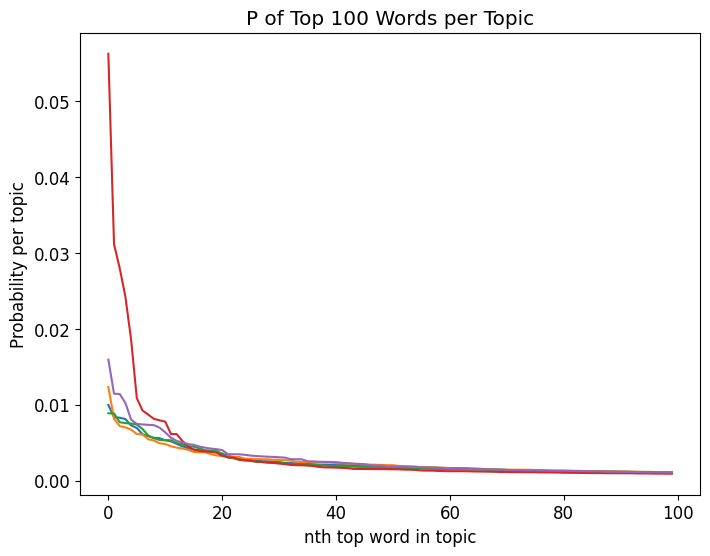

In [ ]:
# plot top words by weight in each topic
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"] = 12
top_n_words = 100
topics = lda.show_topics(num_topics=num_topics, num_words=top_n_words, formatted=False)

for _, infos in topics:
    probs = [prob for _, prob in infos]
    plt.plot(range(top_n_words), probs)

plt.xlabel("nth top word in topic")
plt.ylabel("Probability per topic")
plt.title("P of Top {} Words per Topic".format(top_n_words))
plt.show()

[0 1 2 3 4]


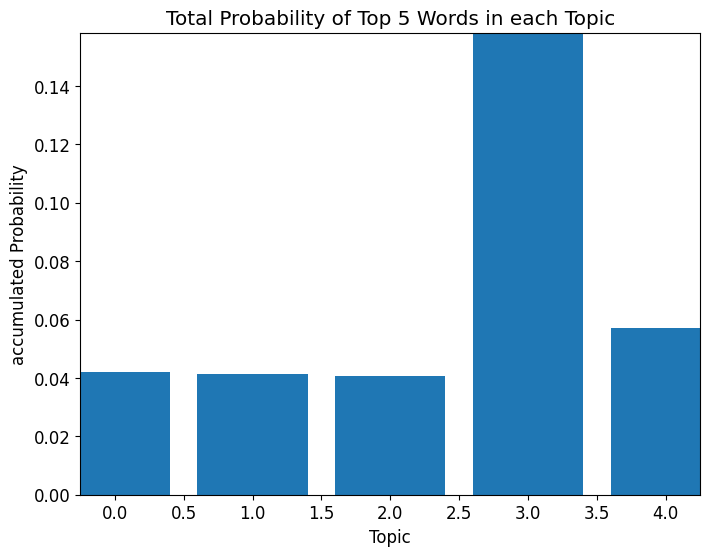

In [ ]:
# sum of probabilities for top n words of each topic
top_probs = []
top_n_words = 5
topics = lda.show_topics(num_words=top_n_words, formatted=False)
for _, infos in topics:
    prob = sum([prob for _, prob in infos])
    top_probs.append(prob)

ind = np.arange(top_n_words)
width = 0.5

print(ind)
fig, ax = plt.subplots()

plt.bar(ind, top_probs)

plt.xlabel('Topic')
plt.ylabel('accumulated Probability')
plt.title('Total Probability of Top {} Words in each Topic'.format(top_n_words))
plt.xlim(-0.25, 4.25)
plt.ylim(0, max(top_probs))
plt.show()

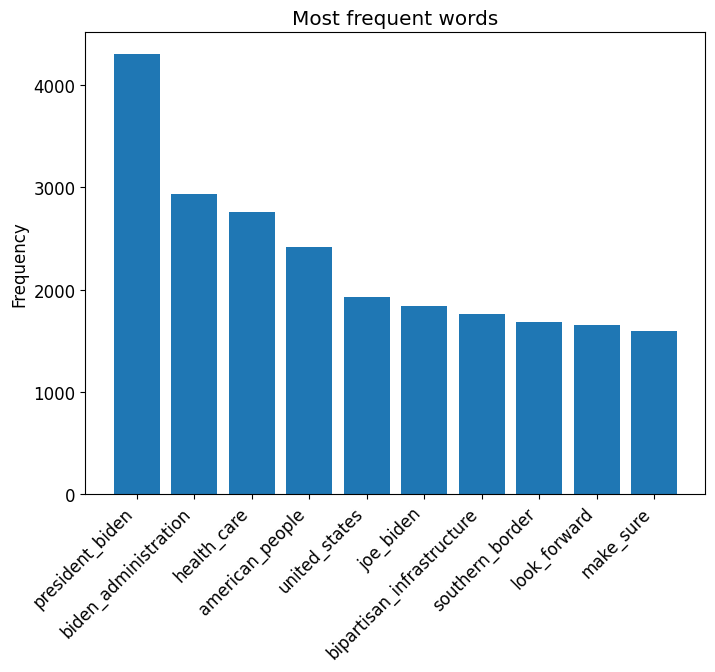

In [ ]:
most_common = dict.most_common(10)
labels, occurrences = zip(*most_common)

plt.bar(labels, occurrences)
plt.xticks(rotation=45, ha="right") 

plt.ylabel("Frequency")
plt.title("Most frequent words")
plt.show()

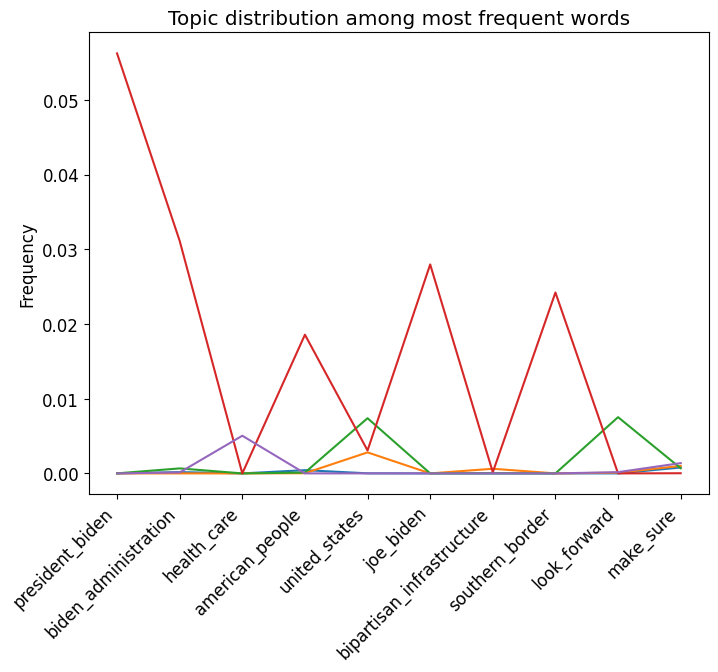

In [ ]:
most_common = dict.most_common(10)
labels, occurrences = zip(*most_common)

probs = []
for label in labels:
    prob_per_word = tuple(map(lambda prob: prob[1], model.get_term_topics(label, minimum_probability=float('-inf'))))
    probs.append(prob_per_word)

probs_per_topic = list(zip(*probs))
for i in range(int(num_topics)):
    plt.plot(labels, list(probs_per_topic[i]))
    plt.xticks(rotation=45, ha="right")

plt.ylabel("Frequency")
plt.title("Topic distribution among most frequent words")
plt.show()
# model.get_term_topics('biden', minimum_probability=float('-inf'))
